## <span style="color:green"> Notebook - Mapping metasomatised domains from MT Models</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In this notebook, we will explore the calculation of first-order metasomatic additions from inputted MT models. For this exercise, we are going to use the model of [Bedrosian et al., 2021](https://doi.org/10.1029/2021GL092970) and cropped temperature model (WINTERC-G) of [Fullea et al., 2021](https://doi.org/10.1093/gji/ggab094). 

In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import pide
from pide.mt.mt_model_read import read_ModEM_rho
from pide.utils.utils import read_csv, associate_coordinates
from pide.utils.gis_tools import lat_lon_to_utm, get_utm_zone_number

#Defining notebook path in the machine that is running.
notebook_path = Path().resolve()

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


First of all, let's read the MT model by using the ***read_ModEM_rho*** function and determine the model center in UTM coordinates to georefererence the model using the functions from ***pide.utils.gis_tools***. We will be using the depths according to 49 and 96 kilometer slices to calculate our metasomatism maps.

In [2]:
wus_rho_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WUS.MT.Bedrosian2021.resistivity.rho')

#model centers for georeferencing
mc_lat = 40.75
mc_lon = -113.25

utm_no = get_utm_zone_number(mc_lon)
mc_x, mc_y = lat_lon_to_utm(mc_lat,mc_lon)

#reading the MT model file
rho, mesh_x, mesh_y, mesh_z = read_ModEM_rho(rho_file_path=wus_rho_path)

#converting x and y to utm coordinates
x = mesh_x
y = mesh_y

#Getting the vertical indexes of 49 and 96 kilometer slices.
idx_49 = (np.abs((mesh_z/1e3) - 49.0)).argmin()
idx_96 = (np.abs((mesh_z/1e3) - 96.0)).argmin()

#Getting the resistivities at 50 and 100 km
rho_49 = rho[idx_49].flatten()
rho_96 = rho[idx_96].flatten()

cond_49 = 1.0/rho_49
cond_96 = 1.0/rho_96


Now, let's read the temperature model with the help of utils.read_csv function. and then georeference them into the UTM coordinates.

In [3]:
#Reading the temperature model
T_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WinterCGTemp_Cropped_WUS.lis')
data_T = read_csv(filename=T_path, delim = ' ')
data_T = np.array(data_T[1:], dtype = float) #Skipping header  with 1:

#Getting the data information
data_T_depth = data_T[:,3]
data_T_temp = data_T[:,4] + 273.15 #converting from C to K
data_T_lat = data_T[:,2]
data_T_lon = data_T[:,1] - 360.0 #Converting it to negative before Greenwich.

#Getting all indices of latitude and longitude by using a single depth.
data_T_lat = data_T_lat[np.where(data_T_depth==-49.0)[0]]
data_T_lon = data_T_lon[np.where(data_T_depth==-49.0)[0]]

#Converting latitude and longitudes into the utm coordinates to match the MT model.
x_T, y_T = lat_lon_to_utm(latitude = data_T_lat, longitude = data_T_lon, zone_number = utm_no)

#Minus model center to georeference all x,y points.
x_T = x_T - mc_x
y_T = y_T - mc_y

#Temperature slices at 49 and 96 km.
T_49 = data_T_temp[np.where(data_T_depth==-49.0)[0]]
T_96 = data_T_temp[np.where(data_T_depth==-97.0)[0]]


Checking whether the model areas are set up accurately by simply plotting the node points.

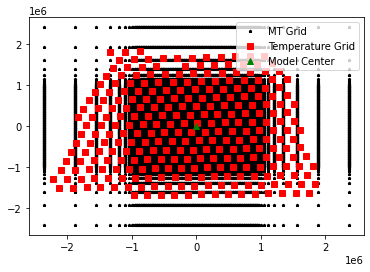

In [4]:
plt.plot(x,y,'*', color = 'k', markersize = 3, label = 'MT Grid')
plt.plot(x_T,y_T, 's', color = 'r',label = 'Temperature Grid')
plt.plot(0,0, '^', color = 'g', label = 'Model Center')
plt.legend()
plt.show()

We also want to interpolate the temperature data between the points so we will have a more accurate distribution of temperature at each MT x,y location.

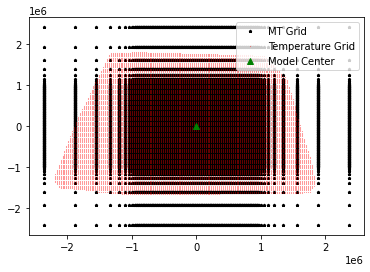

In [5]:
#2D interpolation of Temperature field to make 

x_new = np.arange(np.amin(x_T),np.amax(x_T),30e3) #every 5_000 m
y_new = np.arange(np.amin(y_T),np.amax(y_T),30e3) #every 5_000 m

coords_mesh = np.meshgrid(x_new, y_new)

points_interp = np.column_stack((x_T, y_T))

T_49_interp = griddata(points_interp, T_49, (coords_mesh[0], coords_mesh[1]), method = 'cubic')
T_96_interp = griddata(points_interp, T_96, (coords_mesh[0], coords_mesh[1]), method = 'cubic')

T_49_interp = T_49_interp.flatten()
T_96_interp = T_96_interp.flatten()
coords_x = coords_mesh[0].flatten()
coords_y = coords_mesh[1].flatten()

#Applying mask for nan values at T due to interpolation out of bounds
mask = np.isnan(T_49_interp)
T_49_i = T_49_interp[~mask]
T_96_i = T_96_interp[~mask]
coords_x = coords_x[~mask]
coords_y = coords_y[~mask]

#Plotting the new meshes to check whether the interpolation is made correctly.
plt.plot(x,y,'*', color = 'k', markersize = 3, label = 'MT Grid')
plt.plot(coords_x,coords_y, 's', color = 'r',label = 'Temperature Grid', markersize = 0.1)
plt.plot(0,0, '^', color = 'g', label = 'Model Center')
plt.legend()
plt.show()

Now, we want to find the corresponding index numbers of temperature grid for the each MT grid locality. We can do that by the pide function form ***utils.utils.associate_coordinates*** function.

In [6]:
##associateding coordinates for with

idx_ = associate_coordinates(sample_x = coords_x, sample_y = coords_y, target_x=x, target_y=y, num_cpu = 5)

Now that we have our temperature and MT model, we can set up the compositional environment to calculate the metasomatism maps. We assume a Lherzolitic model. To calculate the all metasomatic additions we will basically calculate the dry lherzolite conductivity at each slice and subtract the real MT model from it:

$$\sigma_{Metasomatism} = \sigma_{Observed} - \sigma_{DryLherzolite} \quad \text{(1)}$$

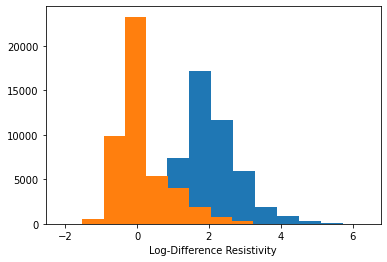

In [7]:
#Setting up and calculating the environment for the 49 km slice and calculating.
p_obj = pide.pide()
p_obj.set_temperature(T_49_i[idx_])
p_obj.set_pressure(49.0 / 33.0) #pressure roughly calculated.
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3,cpx = 0.1)
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

cond_s_49 = p_obj.calculate_conductivity()

#Setting up and calculating the environment for the 49 km slice and calculating.
p_obj = pide.pide()
p_obj.set_temperature(T_96_i[idx_])
p_obj.set_pressure(96.0 / 33.0) #pressure roughly calculated.
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

cond_s_96 = p_obj.calculate_conductivity()

#Calculating the log values of resistivities.
logsynthetic_49 = np.log10(1.0/cond_s_49)
logsynthetic_96 = np.log10(1.0/cond_s_96)

#Calculating the log values of resistivities observed.
logmodel_49 = np.log10(1.0/cond_49)
logmodel_96 = np.log10(1.0/cond_96)

#Let's plot the histogram of differences for each slice.
plt.figure()
ax = plt.subplot(111)
ax.hist(logsynthetic_49-logmodel_49, label = '49 km')
ax.hist(logsynthetic_96-logmodel_96, label = '96 km')
ax.set_xlabel('Log-Difference Resistivity')
plt.show()

Now, let's interpolate these values at 5_000 m to plot nice 2D horizontal sections.

In [8]:
#Setting up the new array.
xi = np.arange(np.amin(x), np.amax(x),5000)
yi = np.arange(np.amin(y), np.amax(y),5000)

x_i,  y_i = np.meshgrid(xi,yi)

points_interp = np.column_stack((x, y))

#Interpolating 49 km
real_model_49 = griddata(points_interp, logmodel_49, (x_i, y_i), method = 'cubic')
synth_model_49 = griddata(points_interp, logsynthetic_49, (x_i, y_i), method = 'cubic')
diff_log_49 = synth_model_49 - real_model_49

#Interpolating 96 km.
real_model_96 = griddata(points_interp, logmodel_96, (x_i, y_i), method = 'cubic')
synth_model_96 = griddata(points_interp, logsynthetic_96, (x_i, y_i), method = 'cubic')
diff_log_96 = synth_model_96 - real_model_96

Now, let's plot the figures in Observed model - Synthetic Model - Model Difference array.

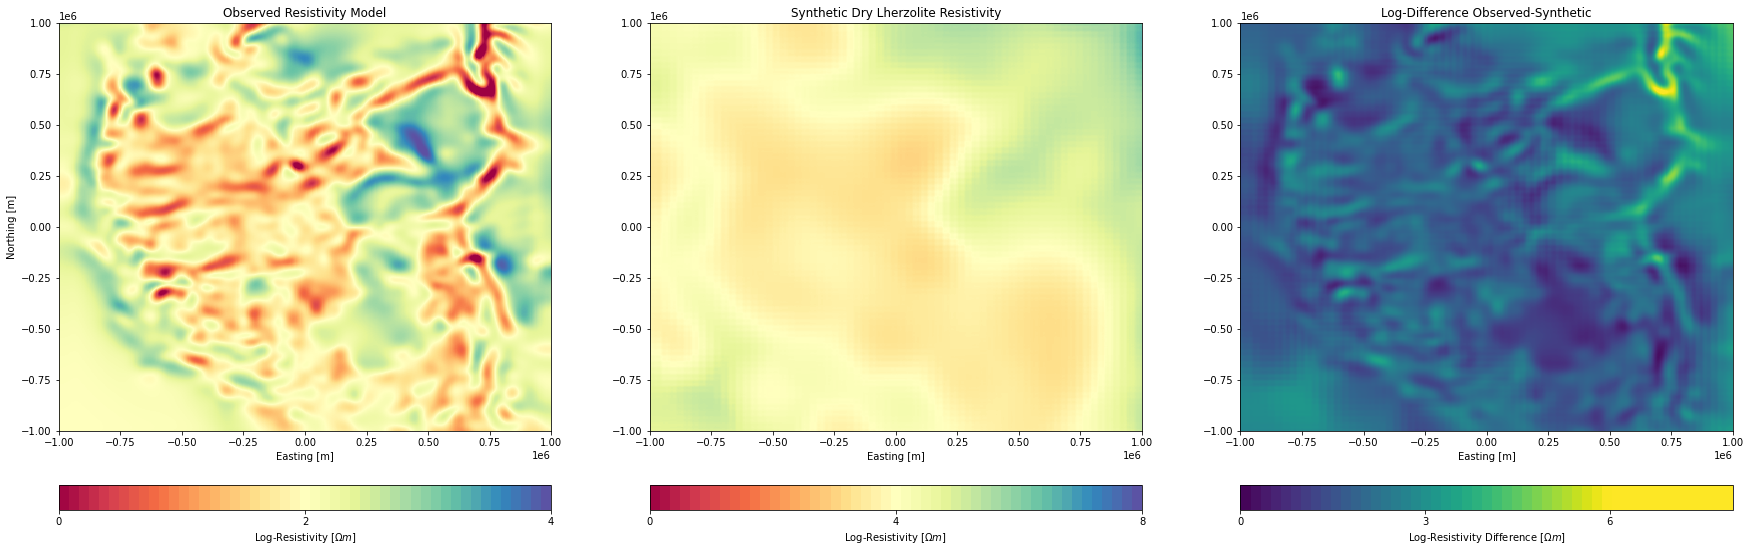

In [9]:
fig = plt.figure(figsize = (30,10))
ax1 = plt.subplot(131)
cax1 = ax1.pcolormesh(xi,yi, real_model_49, cmap = 'Spectral')
cax1.set_clim(0,4)
cbar_ax = fig.colorbar(cax1, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax1, label = 'Log-Resistivity [$\Omega m$]')

ax1.set_xlim(-1e6,1e6)
ax1.set_ylim(-1e6,1e6)
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('Observed Resistivity Model')

ax2 = plt.subplot(132)
cax2 = ax2.pcolormesh(xi,yi, synth_model_49, cmap = 'Spectral')
cax2.set_clim(0,8)
cbar_ax2 = fig.colorbar(cax2, boundaries= np.linspace(0,8), orientation="horizontal", pad=0.1,
			 ticks = [0,4,8], ax = ax2, label = 'Log-Resistivity [$\Omega m$]')

ax2.set_xlim(-1e6,1e6)
ax2.set_ylim(-1e6,1e6)
ax2.set_xlabel('Easting [m]')
ax2.set_title('Synthetic Dry Lherzolite Resistivity')

ax3 = plt.subplot(133)
cax3 = ax3.pcolormesh(xi,yi, diff_log_49, cmap = 'viridis')
cax3.set_clim(0,6)
cbar_ax3 = fig.colorbar(cax3, boundaries= np.linspace(0,8), orientation="horizontal", pad=0.1,
			 ticks = [0,3,6], ax = ax3, label = 'Log-Resistivity Difference [$\Omega m$]')

ax3.set_xlim(-1e6,1e6)
ax3.set_ylim(-1e6,1e6)
ax3.set_xlabel('Easting [m]')
ax3.set_title('Log-Difference Observed-Synthetic')


plt.show()

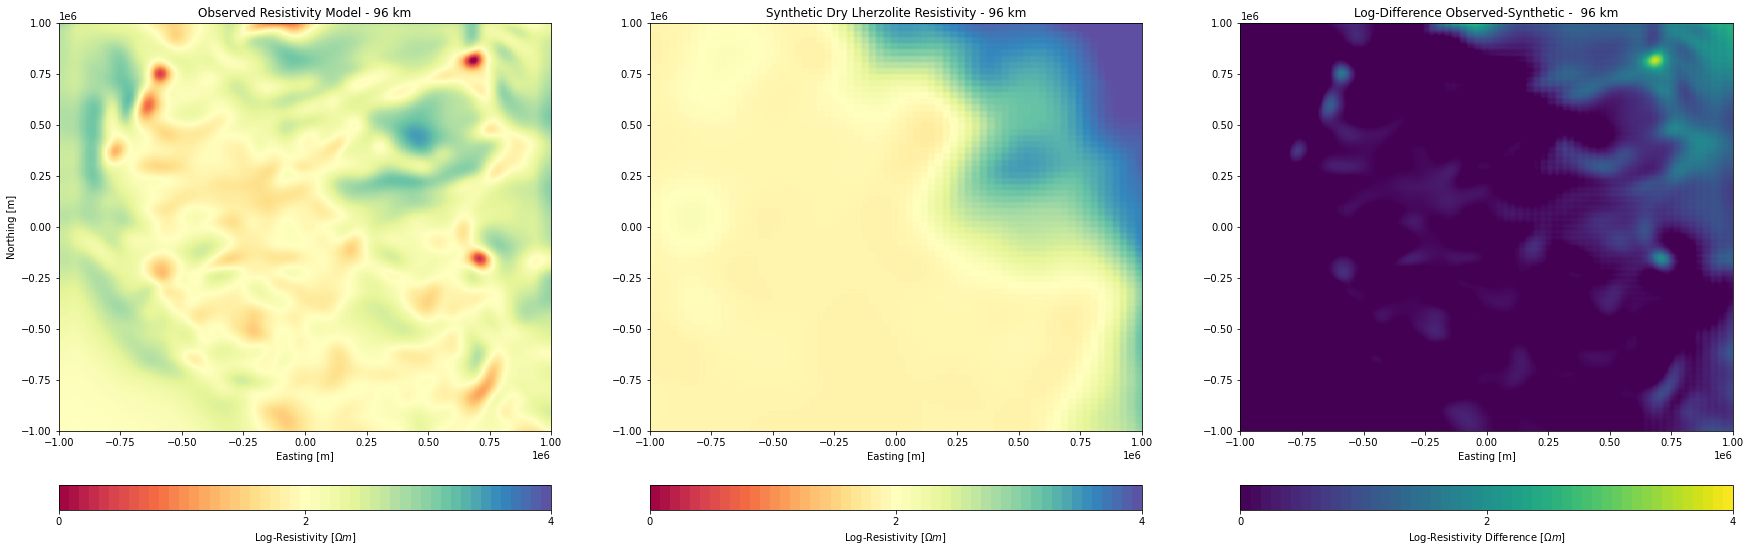

In [10]:
fig = plt.figure(figsize = (30,10))
ax4 = plt.subplot(131)
cax4 = ax4.pcolormesh(xi,yi, real_model_96, cmap = 'Spectral')
cax4.set_clim(0,4)
cbar_ax = fig.colorbar(cax4, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax4, label = 'Log-Resistivity [$\Omega m$]')

ax4.set_xlim(-1e6,1e6)
ax4.set_ylim(-1e6,1e6)
ax4.set_xlabel('Easting [m]')
ax4.set_ylabel('Northing [m]')
ax4.set_title('Observed Resistivity Model - 96 km')

ax5 = plt.subplot(132)
cax5 = ax5.pcolormesh(xi,yi, synth_model_96, cmap = 'Spectral')
cax5.set_clim(0,4)
cbar_ax2 = fig.colorbar(cax5, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax5, label = 'Log-Resistivity [$\Omega m$]')

ax5.set_xlim(-1e6,1e6)
ax5.set_ylim(-1e6,1e6)
ax5.set_xlabel('Easting [m]')
ax5.set_title('Synthetic Dry Lherzolite Resistivity - 96 km')

ax6 = plt.subplot(133)
cax6 = ax6.pcolormesh(xi,yi, diff_log_96, cmap = 'viridis')
cax6.set_clim(0,4)
cbar_ax6 = fig.colorbar(cax6, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax6, label = 'Log-Resistivity Difference [$\Omega m$]')

ax6.set_xlim(-1e6,1e6)
ax6.set_ylim(-1e6,1e6)
ax6.set_xlabel('Easting [m]')
ax6.set_title('Log-Difference Observed-Synthetic -  96 km')

plt.show()